# Introduksjon til vitenskapelige beregninger <br> - Prosjekt 2, Teknisk Fysikk

Johannes A. Kjær - 01.03.2022

In [292]:
##### Useful libraries #####

import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import scipy.optimize as opt



This project is about modelling a ship, and how it twists and rolls in different conditions. To do so, things will be simplified a bit - the ship is going to look like a half-circle on the cross-section. Indeed, only the cross-section of the ship will be considered, and no twisting along the length of the boat will be assumed. Further, the ship will be considered to be compact, which means it is assumed that the ship is solid with a uniform density all the way through.

When the ship is floating on the water, it displaces a volume of water in accordance with Archimedes principle. Looking at the cross-section of the ship, an area is displaced. The displaced voume of water, at equilibrium, can be described by the equation $V_0 = \frac{\sigma\pi R^2 L}{2\sigma_0}$, where $\sigma$ is the density of the ship, $\sigma_0$ is the density of the water, $R$ is the radius of the ship's cross-section, and $L$ is the length of the ship. The cross-section area displaced is then found by dividing by $L$: 
$$
A_0 = \frac{\sigma\pi R^2}{2\sigma_0}
$$ 

This area is the area of the half circle beneath the water line, and can consequently also be described by the sector angle $\gamma$ between the two intersections between the waterline and the ship's hull. At equilibrium name the sector angle is named $\beta$. The area of the whole sector is given by $\frac{\beta R^2}{2}$. 

The triangle can be cut in half, as it is symmetric, and the area of each of these subtriangles are given by their height,<br> $R\cdot\cos\left(\frac{\beta}{2}\right)$, and their width, $R\cdot\sin\left(\frac{\beta}{2}\right)$, divided by two. That means the whole triangle is given by $$2\cdot \frac{R\cdot\cos\left(\frac{\beta}{2}\right) \cdot R\cdot\sin\left(\frac{\beta}{2}\right)}{2} = R^2 \cos\left(\frac{\beta}{2}\right) \cdot \sin\left(\frac{\beta}{2}\right) = \frac12 R^2 \sin(\beta)$$
and the displaced area is given by the triangle subtracted from the circle sector:
$$
A_0 = \frac{\beta R^2}{2} - \frac12 R^2 \sin(\beta) = \frac{R^2}{2} \left(\beta - \sin(\beta)\right)
$$
To find $\beta$ the two expressions for $A_0$ is set equal to each other, and use a numeric method to solve for $\beta$:
$$
A_0 = \frac{\sigma\pi R^2}{2\sigma_0} = \frac{R^2}{2} \left(\beta - \sin(\beta)\right)\\

\Rightarrow \frac{\sigma\pi}{\sigma_0} = \beta - \sin(\beta)\\
\Rightarrow \beta - \sin(\beta) - \frac{\sigma\pi}{\sigma_0} = 0\\
$$

The bisection method will be used, as it is robust, albeit a bit slow, but run time is not a concern for this calculation. The interval will be between the minimum an d maximum possible angles, and as we are concerned with a half circle that is $0$ and $\pi$.


The underlying constants will be decleared up front, so as to make it easier to program the models, and to later test with differing parameters.

In [293]:
##### Useful constants to be decleared once #####

sigma_0 = 1000                                          # kg/m^3    # Density of water
sigma   = 500                                           # kg/m^3    # Density of the compact ship
R       = 10                                            # m         # The radius of the ship's cross-section

A_c     = np.pi*R**2/2                                  # m^2       # The area of the cross-section of the ship
A_0     = sigma*np.pi*R**2/(2*sigma_0)                  # m^2       # The area of water displaced on the 
                                                                    # cross-section at equilibrium                                                     
m       = A_c*sigma                                     # kg/m      # The ship's mass per unit of length
h       = 4*R/(3*np.pi)                                 # m         # The distance from the middle of the deck to  
                                                                    # the center of mass of the ship
I_C     = m*R**2*(1-32/(9*np.pi**2))/2                  # kg*m      # The moment of inertia of the ship through
                                                                    # the axis through the center of mass C
g       = 9.81                                          # m/s**2    # The acceleration due to gravity

In [294]:
##### Defining the bisection method as a function, and using it to find the equilibrium angle beta #####

@jit(nopython=True)
def bisection(f, a, b,m_L=0, tol=1.e-6, max_iter = 100):  # Takes in the function to be evaluated, f, the interval
                                                    # of evaluation a to b, the tolerance in the error, and
                                                    # max iterations instead of using a while loop, risking 
                                                    # the function entering an infinite loop

    assert f(a,m_L)*f(b,m_L)<0, "Error: product was greater than zero, there may be no root in the interval."
    
    for k in range(max_iter):
        c = 0.5*(a+b)                 # Finding the midpoint                   
        if abs(f(c,m_L)) < 1.e-14 or (b-a) < 2*tol:     # The zero is found!
            break 
        elif f(a,m_L)*f(c,m_L) < 0:               
            b = c                     # There is a root in the interval [a, c]
        else:
            a = c                     # There is a root in the interval [c, b]  
    return c, k

@jit(nopython=True)
def functionForBeta(gamma,m_L=0):
    return gamma - np.sin(gamma) - sigma*np.pi/sigma_0

beta, iterations = bisection(functionForBeta,0,np.pi)
print(f"The equilibrium angle Beta = {beta}")

The equilibrium angle Beta = 2.3098822020596512


The bisection method gives that $\beta \approx 2.31 \approx 0.73\pi$, so at equilibrium, a circle sector of an angle somewhat wider than ninety deegrees touches the water.

In [295]:
##### Defining the distance between the metacenter M and the point of bouyancy B as a function of the angle gamma #####

Y_MB_nojit = lambda g: R*(4*np.sin(g/2)**3)/(3*(g-np.sin(g)))     # m     # The distance between M and B
Y_MB = jit(Y_MB_nojit)

# This one may be useful in task 2
# A = lambda gamma: R**2*(gamma-np.sin(gamma))/2  # m^2   # The area of water displaced on the cross-
                                                        # section as a function of the circle sector gamma

In [296]:
##### Calculating the equilibrium heights in relation to the water #####

y_0M = R*np.cos(beta/2)     # The vertical distance from the water to the middle of the deck
y_0C = y_0M - h             # The vertical distance from the water to the center of mass
y_0B = y_0M - Y_MB(beta)    # The vertical distance from the water to the center of gravity of the displaced water
y_0D = y_0M - R             # The vertical distance from the water to the bottom point of the ship

When the ship rotates $\theta$ deegrees around its center of mass C, and is vertically moves $\Delta y_C$; the metacenter M, the center of mass C, and the bottom point of the ship D is displaced as follows:

In [297]:
##### The vertical positions after a vertical displacment and rotation #####
#
#y_thetaM = lambda theta, deltaY: y_0M + 4*R/(3*np.pi) * (np.cos(theta)-1) + deltaY
#y_thetaC = lambda theta, deltaY: y_0C + deltaY                                      # As the rotation is about the 
#                                                                                    # center of mass C it won't cause 
#                                                                                    # C to move vertically
#y_thetaD = lambda theta, deltaY: y_0D + 4*R/(3*np.pi) * (np.cos(theta)-1) + deltaY

When the ship rolls, the amount of water displaced should in theory change a bit, but for simplicity's sake it will be assumed it does not change. Therefore $A=A_0$ will be the amount of displaced water at any point.

To descrive the rolling of the ship, it is useful to introduce the vector $\vec w(t) = \begin{bmatrix}\theta(t) & \omega(t) \end{bmatrix}^T$, where $\theta(t)$ is the angle as a function of time, and $\omega(t) = \frac{d\theta}{dt}$ is the angular velocity as a function of time. These can be described as a system of differential equations. 
For now it will be assumed there is no displacement of the center of mass, and that all forces acting upon the ship is gravity and the bouancy from the water. That is; all forces are assumed to be $F_G = -mg$ and $F_B = A\sigma_0 g$. These forces are equal in magnitude, but in opposite directions; $|F_G| = |F_B|$. When these are the only forces acting upon the ship, the torque is described by:

$$
\Rightarrow \sum \tau = \tau_B = -F_Bh\sin(\theta(t)) = -mgh\sin(\theta(t)) = I_C \frac{d\omega(t)}{dt} = I_C \frac{d^2 \theta}{dt^2} \\
\Rightarrow \frac{d\omega(t)}{dt} = \frac{d^2 \theta}{dt^2} = -\frac{mgh\sin(\theta(t))}{I_C}

$$

The derivative of $\vec w(t)$ can then be expressed as

$$
\frac{d\vec w}{dt} = \begin{bmatrix} \frac{d}{dt}\theta(t) \\ \frac{d}{dt} \omega(t) \end{bmatrix} 
= \begin{bmatrix} \omega(t) \\ -\frac{mgh\sin(\theta(t))}{I_C} \end{bmatrix} = \vec f(t,\vec w)

$$


With an expression for the system of differential equations, it is possible to solve the system by the use of numerical methods, as long as some initial values for the angle and the angular velocity are provided. The simplest way of solving the system is by the use of Euler's method. In simple terms it works by starting at the given intial values, and as an expression for the derivatives at that point is provided, the derivatives are calculated. Following the 'direction' of the derivatives, a step scaled down by the step size, then calculating the same thing for the next step. The step size is normally denoted h, but here it will be denoted $stepSize$ to avoid confusion with the distance between the metacenter and the point of bouancy, as this is especially important in the code.

In [298]:
##### Implementing Euler's method #####

@jit(nopython=True)
def euler(f,w_i,t_i,stepSize):              # Taking in the right side function of the ODE, the current w and t
                                            # values, and the step size h

    w_i1 = w_i + stepSize*f(t_i,w_i)        # Computing the next next step
    t_i1 = t_i + stepSize
    return w_i1, t_i1

##### Defining a general ODE solver, which takes in a method to compute the single steps #####

@jit(nopython=True)
def ODEsolver(f,y_0,a,b,method,stepSize=1e-3):  # Taking in the right side function of the ODE, the initial value
                                                # of the ODE, the lower and upper ends of the interval a and b,
                                                # and the method to use for solving the ODE.

    iter = int((b-a)/stepSize)                  # Calculating the integer number of iterations/steps needed to 
                                                # cover the whole interval

    w = np.zeros((iter+1,len(y_0)))             # Array's to store the t's and w's of each step of the given
    t = np.zeros(iter+1)                        # method. Allocating memory by setting the length of the arrays up front.
    
    w[0] = y_0                                  # Setting the first solution of the ODE to be the initial value                     
    t[0] = a                                    # Setting the first step to start at the start of the interval

    for i in range(iter):                       # Stopping the iterations before exiting the interval
        w[i+1], t[i+1] = method(f,w[i],t[i],stepSize) # Performing one step of the given method
    
    return w, t


In [299]:
##### Defining the system in python, and using Euler's method to solve the system #####

@jit(nopython=True)
def dwdt(t,w):                      # Function to return the derivative of the function
    dw = np.array([
        w[1],
        -m*g*h*np.sin(w[0])/I_C
    ])
    return dw

w_0 = np.array([
    2*np.pi*1/18,
    0
])



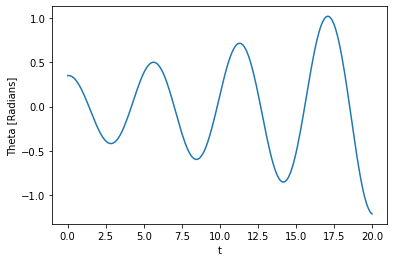

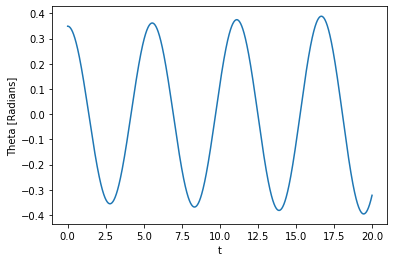

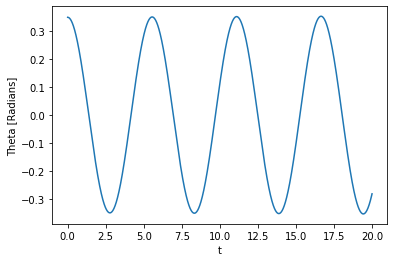

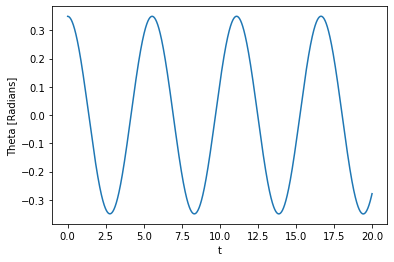

In [300]:
##### Plotting theta as a function of t #####

def plottingTheta():
    plt.plot(stepsT,solvedW[:,0])
    plt.xlabel("t")
    plt.ylabel("Theta [Radians]")

    #plt.plot(stepsT,solvedW[:,1])      # Just plotting some more graphs for fun
    plt.show()

    #plt.plot(solvedW[:,0],solvedW[:,1]
    #plt.show()

for n in range(1,5):                                            # Iterating to test different step sizes
    solvedW, stepsT = ODEsolver(dwdt,w_0,0,20,euler,10**(-n))   # Solving the system with different step sizes
    plottingTheta()


From solving the system of differential equations with differing step sizes $\left(10^{-n}, n \in \left\{1,2,3,4 \right\} \right)$, it is apparent that any step sizes of $10^{-1}$ is insufficient for solving the system with enough precision, as the system diverges. This seems to be the case for, albeit more slowly, step sizes of $10^{-2}$ too. the difference between step sizes of $10^{-3}$ and $10^{-4}$ seem indiscernable to the naked eye. Therfore step sizes of $10^{-3}$ will be used. This is retroactively set as the default value for the _ODEsolver()_ function.

In [301]:
##### Defining the system with the simplified condition that sin(theta) ~= theta #####

@jit(nopython=True)
def dwdtapprox(t,w):                      # Function to return the derivative of the function
    dw = np.array([
        w[1],
        -m*g*h*w[0]/I_C
    ])
    return dw

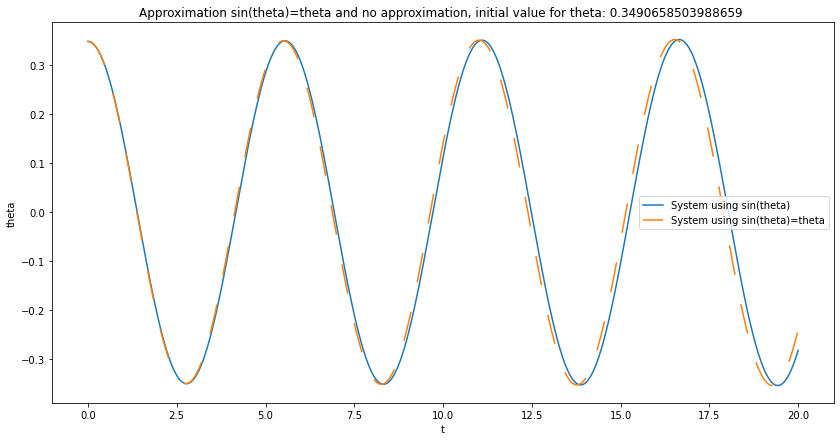

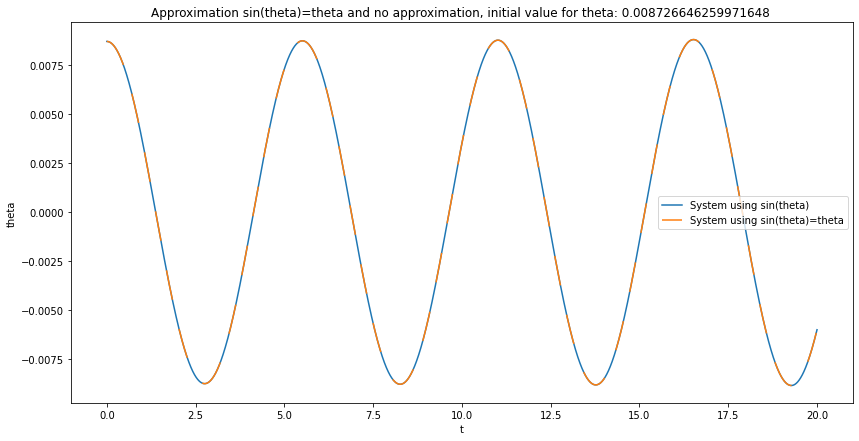

In [302]:
##### Calculating and plotting the system and the approximation of the system, #####
##### with both provided sets of initial conditions                            #####

w_0Second = np.array([
    np.pi*1/360,
    0
])

def compareApproximation(initialW):
    solvedW, stepsT = ODEsolver(dwdt,initialW,0,20,euler)
    solvedWapprox, stepsTapprox = ODEsolver(dwdtapprox,initialW,0,20,euler)

    plt.figure(figsize=(14,7))
    plt.plot(stepsT,solvedW[:,0])
    plt.plot(stepsTapprox,solvedWapprox[:,0],linestyle=(0,(20,20)))
    plt.legend(["System using sin(theta)","System using sin(theta)=theta"])
    plt.title(f"Approximation sin(theta)=theta and no approximation, initial value for theta: {initialW[0]} ")
    plt.xlabel("t")
    plt.ylabel("theta")
    plt.show()

compareApproximation(w_0)
compareApproximation(w_0Second)

    

As the graphs show, the approximation is very accurate for small angles, although it is a bit inaccurate when the angle increases.

Runge-Kutta methods are a family of methods for solving differential equations numerically. A particularly useful one is the fourth order Runge-Kutta method, because it is both simple to implement in programming, and it is very effetive as it is a fourth order method. Therefore it will be implemented in the following code block.

In [303]:
##### Defining the Runge Kutta method for solving differential systems #####

@jit(nopython=True)
def RK4(f,w_i,t_i,stepSize):
    s1 = f( t_i         , w_i           )
    s2 = f( t_i + stepSize/2   , w_i + s1*stepSize/2  )
    s3 = f( t_i + stepSize/2   , w_i + s2*stepSize/2  )
    s4 = f( t_i + stepSize     , w_i + s3*stepSize    )

    t_i1 = t_i + stepSize

    return w_i + stepSize*(s1+2*s2+2*s3+s4)/6, t_i1


To find the error of the numerical solution, an analytical solution has to be found.

Now, this model of a ship is not too accurate. The amount of displaced water should change a bit when the ship rolls, the mass center should move a bit because of the rolling, the ship should experience some friction moving against the water, and the ship could potentially contain some unsecured cargo. All these things have up to now been ignored. Henceforth, more and more of them will be considered when modeling the ship.

Starting by considering the fact that the amount of displaced water will not stay constant when the ship rolls, a new system of differential equations need to be derived:

$$
\vec w = \begin{bmatrix} \theta(t) & \omega(t) & x(t) & y(t) & v_x(t) & v_y(t) \end{bmatrix}^T \\
$$
First the torque and its first and second derivatives are found for this new coupled system:
$$

\sum \tau = \tau_B = -F_Bh\sin(\theta(t)) = -A\sigma_0 g h \sin(\theta(t)) = I_C \frac{d\omega(t)}{dt} = I_C \frac{d^2 \theta}{dt^2} \\

\Rightarrow \frac{d^2 \theta}{dt^2} = \frac{d\omega(t)}{dt} = -\frac{A\sigma_0 g h \sin(\theta(t))}{I_C}\\

$$
Now, here the center of mass is allowed to move vertically, so $\Delta y_C \neq 0$. To describe the vertical position of the center of mass, a position vector $\vec R$ is introduced. From Newton's laws of motion the following must necessarily be correct, where $\vec F$ is the force vector, $\vec A$ is the accereration vector, and $\vec V$ is the velocity vector.
$$
\sum \vec F = m\vec A = m\frac{d\vec V}{dt} = m\frac{d^2\vec R}{dt^2}
$$
The sum of the forces, in this simplified case, is simply the sum of the gravity and the bouancy. Replacing $\vec R$ with $y(t)$ and $\vec V$ with $v_y(t)$, the following derivation can be done:

$$
\sum F = F_G + F_B = -mg + A\sigma_0 g = m\frac{d^2 y(t)}{dt^2} \\
\Rightarrow \frac{d^2 y(t)}{dt^2} = \frac{d v_y(t)}{dt} = g\frac{A\sigma_0 - m}{m}
$$

The replacements between vector and scalars are allowed because all forces in this simplified version of the problem are along the y-axis. Further, the simplification also means that the x-coordinate does not change, that is, its derivative is zero, which also means that its second derivative, the derivative of the velocity, is zero:

$$
\frac{dx(t)}{dt} = 0 \Rightarrow \frac{d^2x(t)}{dt^2} = \frac{dv_x(t)}{dt} = 0
$$

In total that gives the following system:

$$
\frac{d}{dt}\vec w = \begin{bmatrix} \frac{d}{dt}\theta(t) \\ \frac{d}{dt}\omega(t) \\ \frac{d}{dt}x(t) \\ \frac{d}{dt}y(t) \\ \frac{d}{dt}v_x(t) \\ \frac{d}{dt}v_y(t) \end{bmatrix}
= \begin{bmatrix} \omega(t) \\ -\frac{A\sigma_0 g h \sin(\theta(t))}{I_C} \\ 0 \\ v_y(t) \\ 0 \\ g\frac{A\sigma_0 - m}{m} \end{bmatrix}
$$

As we are not dealing with a constant amount of displaced water anymore, the area of displaced water A is a function of the circle sector touching the water, which again is a function of the angle $\theta$ and the vertical displacement $y(t)$. To substitute for A, and then $\gamma$, in the equations of the system would however lead to cumbersome equations, so their equations are presented here, implemented in the code, and called upon when needed:
$$
A = \frac{1}{2}R^2(\gamma-\sin(\gamma)) \\
\gamma = 2\arccos\left(\cos\left(\frac{\beta}{2}\right)-\frac{4}{3\pi}\left(1-\cos(\theta)+\frac{y_C-y_C^0}{R}\right) \right) \\
$$

In [304]:
##### Defining the area as a function of gamma, and gamma as a function of the rotation and vertical displacement #####

A_noJit = lambda gam: R**2*(gam-np.sin(gam))/2    # m^2     # The area of water displaced on the 
                                                            # cross-section as a function of gamma
A       = jit(A_noJit)                                      # Speeding up the area function with jit, to be able
                                                            # to use it in other jitted functions.
gamma_noJit   = lambda theta, y_C, b=beta: 2*np.arccos(np.cos(b/2)-(4/(3*np.pi))*(1-np.cos(theta))+(y_C-y_0C)/R)    # Radians
gamma   = jit(gamma_noJit)


In [305]:
##### Defining the derivative of the differential equation vector, and the initial values #####

@jit(nopython=True)
def dwdtSecond(t,w):
    dw = np.array([
        w[1],
        -(A(gamma(w[0],w[3])) *sigma_0*g*h*np.sin(w[0]))/I_C,
        0,
        w[5],
        0,
        g * (( A(gamma(w[0],w[3])) *sigma_0 - m)/m)
    ])
    return dw

w_0Third = np.array([
    1/18 * 2*np.pi,
    0,
    0,
    y_0C,
    0,
    0
])

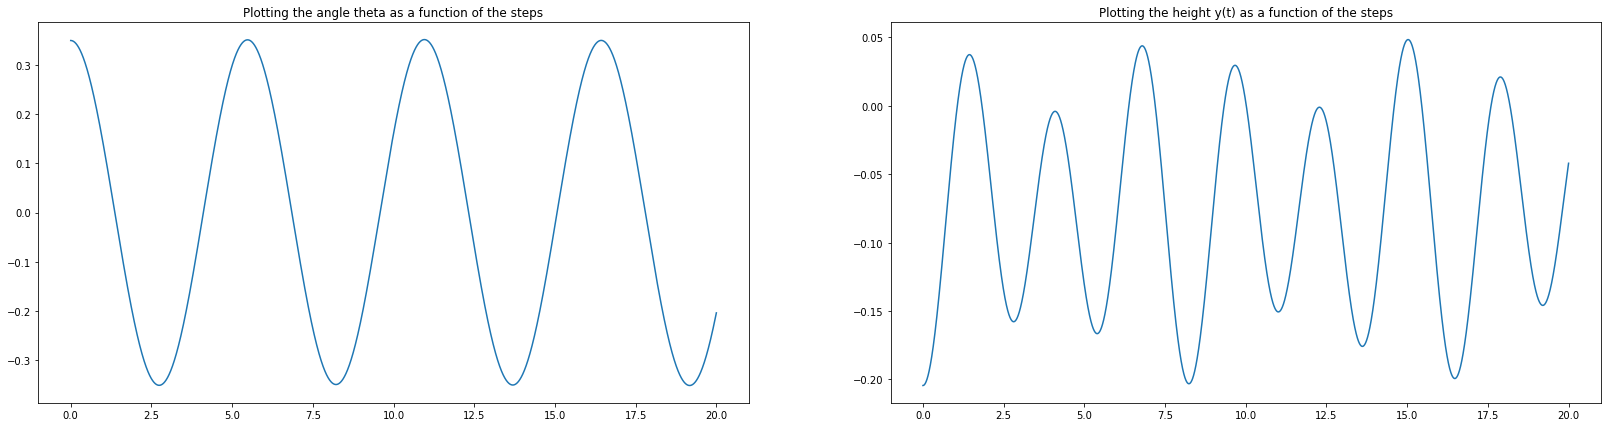

In [306]:
def solveNPlotODE():
    solvedW, stepsT = ODEsolver(dwdtSecond,w_0Third,0,20,RK4)
    plt.figure(figsize=(28,7))

    plt.subplot(1,2,1)
    plt.plot(stepsT,solvedW[:,0])
    plt.title("Plotting the angle theta as a function of the steps")

    plt.subplot(1,2,2)
    plt.plot(stepsT,solvedW[:,3])
    plt.title("Plotting the height y(t) as a function of the steps")


    plt.show()
solveNPlotODE()



As this is a model of a ship, it should not be able to use all values of $\theta$ - as certain values of $\theta$ would imply it has capsized. To account for this, when the ship rolls enough for the edge to dip beneath water, the angle is set to $\pm \frac{\pi}{2}$, depending upon the direction in which the ship rolled, and all other values in the system are set to zero.

In [307]:
##### Implementing a function to check if the ship capsized, and setting the values of    #####  
##### the system henceforth to zero* if it did, also returning whether it capsized or not #####
# * Exception for theta

@jit(nopython=True)
def doesShipCapsize(f,w0):
    solvedW, stepsT = ODEsolver(f,w0,0,20,RK4)
    capsized = False
    thetaiMinus1sign = 0
    for i in range(len(stepsT)):
        if capsized:
            solvedW[i,:] = np.array([
                thetaiMinus1sign*np.pi/2,
                0.0,0.0,0.0,0.0,0.0
            ])
        else:
            if solvedW[i,0] > (np.pi- gamma(solvedW[i,0],solvedW[i,3]) )/2:
                capsized = True
                thetaiMinus1sign = np.sign(solvedW[i-1,0])

                solvedW[i,:] = np.array([
                thetaiMinus1sign*np.pi/2,
                0,0,0,0,0
                ])
    return solvedW, stepsT, capsized
        
##### Function for capsizing the ship, so that the smallest initial value of omega causing the ship to capsize can be found #####
@jit(nopython=True)
def capsizeTheShip(f):
    omegas = np.linspace(0.4,0.5,100)
    capsizeOmegas = []
    for omega in omegas:
        w0 = np.array([
            0,
            omega,
            0,
            y_0C,
            0,
            0
        ])
        solvedW, stepsT, capsized = doesShipCapsize(f,w0)
        if capsized:
            capsizeOmegas.append(omega)
    return capsizeOmegas[0]
    
print("The smallest initial omega causing the ship to capsize is: ",capsizeTheShip(dwdtSecond))  

    

The smallest initial omega causing the ship to capsize is:  0.43333333333333335


As the code suggests, the smallest initial value of $\omega(t)$, when initial values of the other values are either zero or their equilibrium values, causing the ship to capsize is ~$0.433$. The searching range was chosen ad-hoc - running the simulation over larger value intervals of $\omega_0$'s, and then narrowing the search a bit around the values produced.

What use is a ship without its cargo? That's the next thing to consider, how will cargo influence the stabiblity of the ship? First of all, the mass of the cargo, here denoted $m_L$, will increase the total mass of the ship, giving new equilibrium values. The cargo will also cause a torque when it is not situated directly over the center of mass. And just for fun (and a more interesting set of differential euations), the cargo will not be secured - it will move about without any friction, in deterministic ways only dependent on the angle $theta$ of the deck. Further, it will cause the ship to move somewhat in both $x$- and $y$-direction. The ship is carrying a special cargo, that is, cargo space efficient enough to be a point mass. It moves about the deck with a velocity $v_L = \frac{ds_L}{dt}$, where $s_L$ is the position of the cargo in relation to the center of the deck (the meta center).

The system of differential equations needs then to include values for the derivatives of $s_L$ and $v_L$. The derivative of $s_L$ is already given, $\frac{ds_L}{dt} = v_L$, while the derivative of the velocity is given by Newton's laws:
$$
\frac{dv_L}{dt} = - g \sin(\theta)
$$


Now the x-coordinate of the mass center is not fixed anymore, so an expression for those derivatives will need to be derived to. The derivative of the position is simply the velocity in the x-direction. The derivative of the velocity is equal to the sum of the forces acting upon the ship in x-direction:

$$
(m+m_L)\frac{dv_x}{dt} = \sum F_x = F_L^x = m_L g \cos(\theta) \sin(\theta)\\
\Rightarrow \frac{dv_x}{dt} = \frac{m_L}{m+m_L} g \cos(\theta) \sin(\theta)
$$

The cargo affects the y-coordinate of the ship's mass center too, so the expression for that will need to be rederived:
$$
(m+m_L)\frac{dv_y}{dt} = \sum F_y = F_G + F_B + F_L^y = -(m+m_L)g + A\sigma_0 g - m_L g \cos^2(\theta) \\
\Rightarrow \frac{dv_y}{dt} = \frac{g(A\sigma_0 - m_L \cos^2(\theta) - m-m_L)}{m+m_L}
$$

The torque also changes:

$$
\sum \tau = \tau_B + \tau_L = -F_Bh\sin(\theta(t)) -m_L g\cos(\theta)s_L = -A\sigma_0 g h \sin(\theta(t)) -m_L g\cos(\theta)s_L = I_C \frac{d\omega(t)}{dt} = I_C \frac{d^2 \theta}{dt^2} \\
\Rightarrow \frac{d\omega(t)}{dt} = -\frac{A\sigma_0 g h \sin(\theta(t)) +m_L g\cos(\theta(t))s_L}{I_C}

$$

The variables does then combine into the system of differential equations as such:

$$
\frac{d}{dt}\vec w = 
\begin{bmatrix} 
    \frac{d}{dt}\theta(t) \\ 
    \frac{d}{dt}\omega(t) \\ 
    \frac{d}{dt}x(t) \\ 
    \frac{d}{dt}y(t) \\ 
    \frac{d}{dt}v_x(t) \\ 
    \frac{d}{dt}v_y(t) \\ 
    \frac{d}{dt}s_L(t) \\ 
    \frac{d}{dt}v_L(t) 
\end{bmatrix}

= \begin{bmatrix} 
    \omega(t) \\ 
    -\frac{A\sigma_0 g h \sin(\theta) + m_L g\cos(\theta)s_L}{I_C} \\ 
    v_x(t) \\ 
    v_y(t) \\ 
    \frac{m_L}{m+m_L} g \cos(\theta) \sin(\theta) \\ 
    \frac{g(A\sigma_0 - m_L \cos^2(\theta) - m-m_L)}{m+m_L} \\ 
    v_L(t) \\ 
    - g \sin(\theta) 
\end{bmatrix}
$$

The deck of the ship is only so long, so the cargo either needs to stop as it hits the railng, or fall of if there is no railing. For now it will be assumed there is no railing. To model the cargo falling of, the mass of the cargo is set to zero as soon as the cargo's position exceeds the radius. As all the interactions of the cargo is proportional to the mass of the cargo, setting its mass equal to zero removes all its interactions with the ship.

As the mass have increased, all the equilibrium values do now need to be recalculated. The first is the equilibrium angle $\beta$, which is given from Archimedes law that gives that one mass can displace another of equal mass:

$$
A_0 \sigma_0 = \sigma \frac{\pi R^2}{2} + m_L \\
\Rightarrow A_0 = \frac{\sigma \frac{\pi R^2}{2} + m_L}{\sigma_0} = \frac{R^2}{2} (\beta - \sin(\beta)) \\
\Rightarrow \frac{R^2}{2} (\beta - \sin(\beta)) - \frac{\sigma \frac{\pi R^2}{2} + m_L}{\sigma_0} = 0
$$

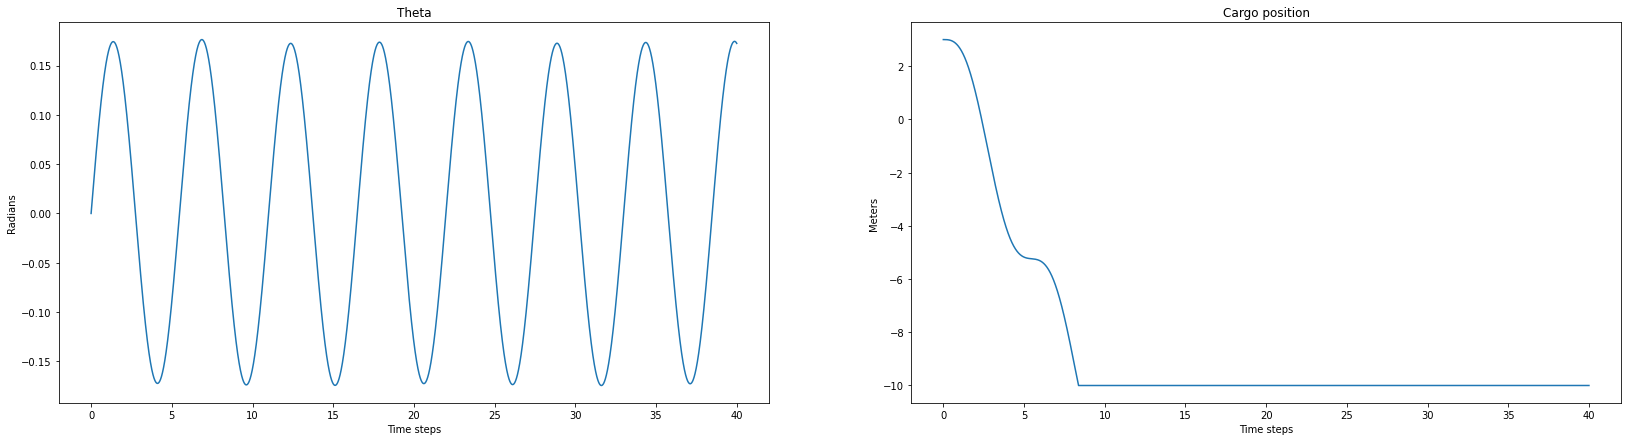

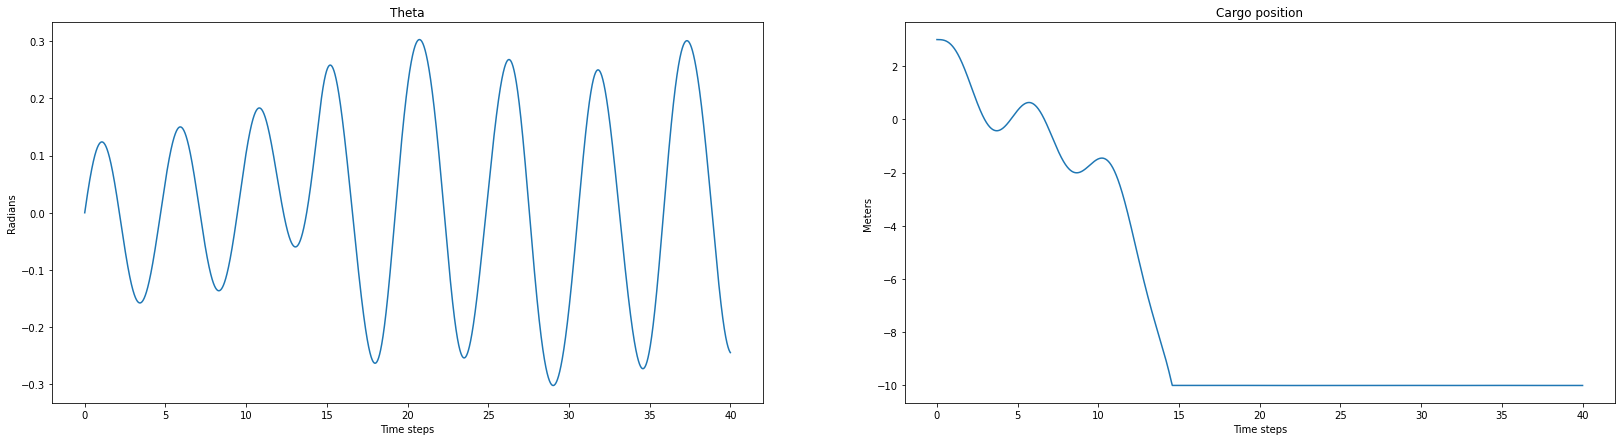

In [308]:
##### Function for calculating the new equilibrium angle beta #####

@jit(nopython=True)
def newFunctionForBeta(gamma,m_L):
    betaTry = R**2/2 *(gamma-np.sin(gamma)) - (sigma*np.pi*R**2/2 + m_L)/sigma_0 
    return betaTry

##### Defining a new version of the Runge Kutta method, to be able to take in the cargo mass as an argument #####

@jit(nopython=True)
def RK4_cargo(f,w_i,t_i,stepSize, otherParameters):
    s1 = f( t_i                , w_i                  , otherParameters)
    s2 = f( t_i + stepSize/2   , w_i + s1*stepSize/2  , otherParameters)
    s3 = f( t_i + stepSize/2   , w_i + s2*stepSize/2  , otherParameters)
    s4 = f( t_i + stepSize     , w_i + s3*stepSize    , otherParameters)

    t_i1 = t_i + stepSize

    return w_i + stepSize*(s1+2*s2+2*s3+s4)/6, t_i1

##### Defining an ODE solver which restricts or lets the cargo fall of the ship. ##### 

@jit(nopython=True)
def ODEcargo(f,y_0,a,b,otherParameters,method=RK4_cargo,stepSize=1e-3):   # Taking in the right side function of the ODE, the initial value
                                                # of the ODE, the lower and upper ends of the interval a and b,
                                                # and the method to use for solving the ODE.

    
    ##### Calculating the new equilibrium angle beta #####

    beta, iterations = bisection(newFunctionForBeta,0,np.pi,otherParameters[0])
    otherParameters[2] = beta   # Saving the new beta
    
    ##### Solving the system #####
    iter = int((b-a)/stepSize)                  # Calculating the integer number of iterations/steps needed to 
                                                # cover the whole interval

    w = np.zeros((iter+1,len(y_0)))             # Array's to store the t's and w's of each step of the given
    t = np.zeros(iter+1)                        # method. Allocating memory by setting the length of the arrays up front.
    
    w[0] = y_0                                  # Setting the first solution of the ODE to be the initial value                     
    t[0] = a                                    # Setting the first step to start at the start of the interval

    for i in range(iter):                       # Stopping the iterations before exiting the interval
        w[i+1], t[i+1] = method(f,w[i],t[i],stepSize, otherParameters) # Performing one step of the given method
        if np.abs(w[i+1][6]) > R:               # Checking if the cargo have fallen of
            if otherParameters[1]:
                otherParameters[0] = 0          # Removing the mass of the cargo
                w[i+1][7] = 0                   # Removing any velocity the cargo have, so that it will stand still just of the edge of the ship
                                                # This will make it easier to see in the graphs whether it have fallen of or not.
            else:
                w[i+1][6] = R * np.sign(w[i+1][6])  # 'Moves' the cargo back to the edge of the ship, when it otherwise would have fallen of

    return w, t


##### Defining the new system #####

@jit(nopython=True)
def dwdtThird(t,w,otherParameters):
    dw = np.array([
        w[1],
        -(A(gamma(w[0],w[3],otherParameters[2])) *sigma_0*g*h*np.sin(w[0]) + otherParameters[0]*g*np.cos(w[0])*w[6])/I_C,
        w[4],
        w[5],
        otherParameters[0]*g*np.cos(w[0])*np.sin(w[0])/(m+otherParameters[0]),
        g * (( A(gamma(w[0],w[3],otherParameters[2])) *sigma_0 - m - otherParameters[0] - otherParameters[0]*np.cos(w[0])**2)/(m+otherParameters[0])),
        w[7],
        -g*np.sin(w[0])
    ])
    return dw

w_0Fourth = np.array([
    0,
    0.2,
    0,
    y_0C,
    0,
    0,
    3,
    0
])



##### Calculating and plotting the system. #####
def calNplot(m_L,cargoFall):
    parameters = np.array([m_L,cargoFall,beta])
    solvedW, stepsT = ODEcargo(dwdtThird,w_0Fourth,0,40,parameters)
    plt.figure(figsize=(28,7))

    plt.subplot(1,2,1)
    plt.plot(stepsT,solvedW[:,0])
    plt.title("Theta")
    plt.xlabel("Time steps")
    plt.ylabel("Radians")

    plt.subplot(1,2,2)
    plt.plot(stepsT,solvedW[:,6])
    plt.title("Cargo position")
    plt.xlabel("Time steps")
    plt.ylabel("Meters")

    plt.show()
calNplot(0.001*m,True)
calNplot(0.08*m,True)

Here the angle $\theta$ and $s_L$, the position of the cargo is plotted as functions of the time steps.

Also plotting the same situation with railings.

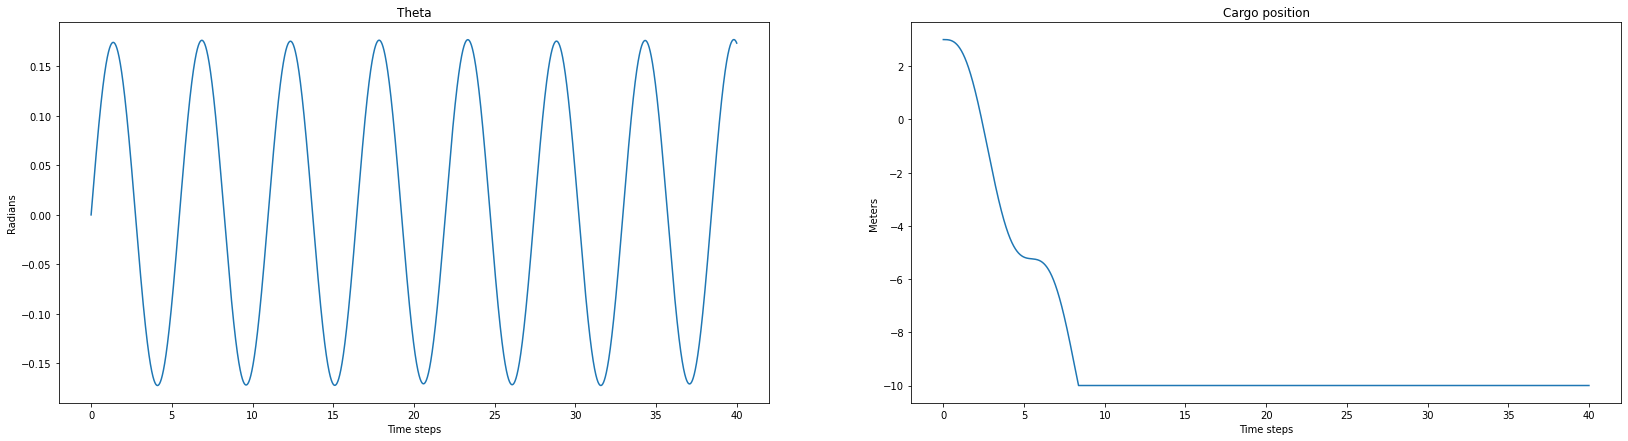

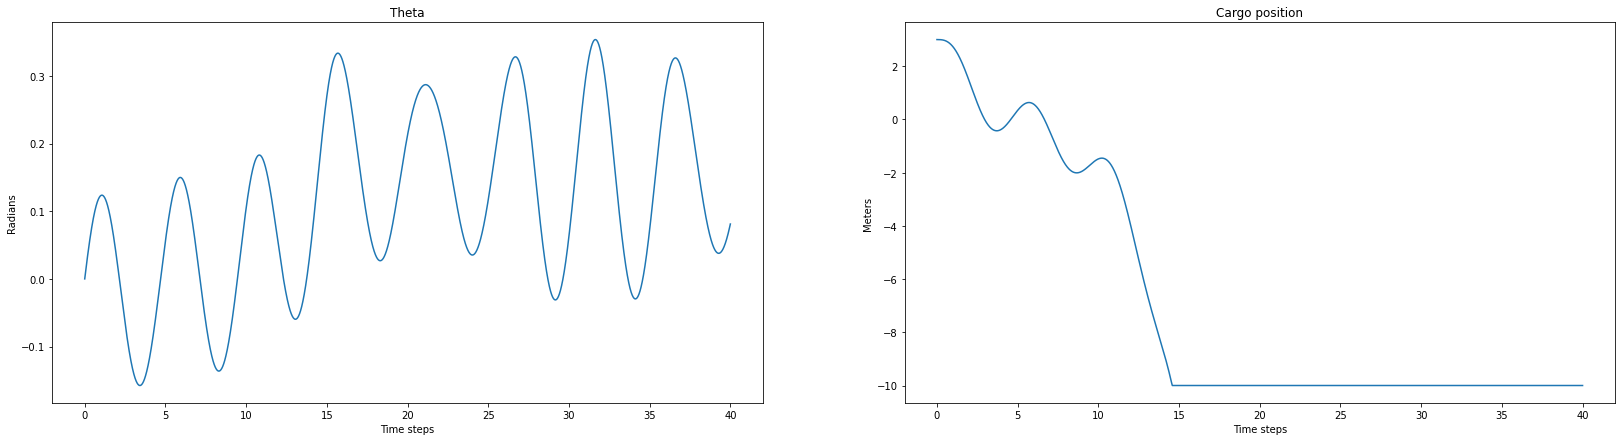

In [309]:
calNplot(0.001*m,False)
calNplot(0.08*m,False)

Here we can se that the problem still persists with the railings, but as the cargo does not yeet of, the ship starts to lean towards the side of the cargo (When the cargo is heavy enough), wobbling to the side of $\theta = 0$.

Now some more components are going to be implemented, first among them the friction between the ship and the water. It will be modeled as attacking in one attack point D, but beeing proportional to the arc length given by $R\gamma$, and to the angular velocity $\omega$:

$$
f = -k_f R\gamma \omega
$$

Here $k_f$ is a proportionality constant.


The wind and waves are also acting upon the ship. They can be modeled as a harmonically oscillating force:

$$
F_w = F_0 \cos(\omega_w t)
$$

$F_0$ is the amplitude of the harmonic force, and $\omega_w$ is a constant, $t$ is the time steps.

These two forces does also lead to two new torques:

$$
\tau_f = f\left( y_C - \left( R \left( \cos\left(\frac{\gamma}{2}\right) -1 \right) \right) \right) \\
\& \\
\tau_w = F_w y_C
$$

This of course leads to some new formulas for the forces:

$$
(m+m_L)\frac{dv_x}{dt} = \sum F_x = F_L^x + f + F_w = m_L g \cos(\theta) \sin(\theta) - k_fR\gamma\omega + F_0\cos(\omega_w t) \\
\Rightarrow \frac{dv_x}{dt} = \frac{m_L g \cos(\theta) \sin(\theta) - k_fR\gamma\omega + F_0\cos(\omega_w t)}{m+m_L}
$$

$$
\sum \tau = \tau_B + \tau_L + \tau_f + \tau_w 
= -F_Bh\sin(\theta(t)) -m_L g\cos(\theta)s_L + f\left( y_C - \left( R \left( \cos\left(\frac{\gamma}{2}\right) -1 \right) \right) \right) + F_w y_C \\
= -A\sigma_0 g h \sin(\theta(t)) -m_L g\cos(\theta)s_L -k_fR\gamma\omega\left(y_C-\left(R\left(\cos\left(\frac{\gamma}{2}\right)-1\right)\right)\right) + F_0 \cos(\omega_w t) y_C
= I_C \frac{d\omega(t)}{dt} = I_C \frac{d^2 \theta}{dt^2} \\

\Rightarrow \frac{d\omega(t)}{dt} = \frac{-A\sigma_0 g h \sin(\theta(t)) -m_L g\cos(\theta)s_L -k_fR\gamma\omega\left(y_C-\left(R\left(\cos\left(\frac{\gamma}{2}\right)-1\right)\right)\right) + F_0 \cos(\omega_w t) y_C}{I_C}

$$

That gives the following expression for the system:
$$
\frac{d}{dt}\vec w = 
\begin{bmatrix} 
    \frac{d}{dt}\theta(t) \\ 
    \frac{d}{dt}\omega(t) \\ 
    \frac{d}{dt}x(t) \\ 
    \frac{d}{dt}y(t) \\ 
    \frac{d}{dt}v_x(t) \\ 
    \frac{d}{dt}v_y(t) \\ 
    \frac{d}{dt}s_L(t) \\ 
    \frac{d}{dt}v_L(t) 
\end{bmatrix}

= \begin{bmatrix} 
    \omega(t) \\ 
    \frac{-A\sigma_0 g h \sin(\theta(t)) -m_L g\cos(\theta)s_L -k_fR\gamma\omega\left(y_C-\left(R\left(\cos\left(\frac{\gamma}{2}\right)-1\right)\right)\right) + F_0 \cos(\omega_w t) y_C}{I_C} \\ 
    v_x(t) \\ 
    v_y(t) \\ 
    \frac{m_L g \cos(\theta) \sin(\theta) - k_fR\gamma\omega + F_0\cos(\omega_w t)}{m+m_L} \\ 
    \frac{g(A\sigma_0 - m_L \cos^2(\theta) - m-m_L)}{m+m_L} \\ 
    v_L(t) \\ 
    - g \sin(\theta) 
\end{bmatrix}
$$

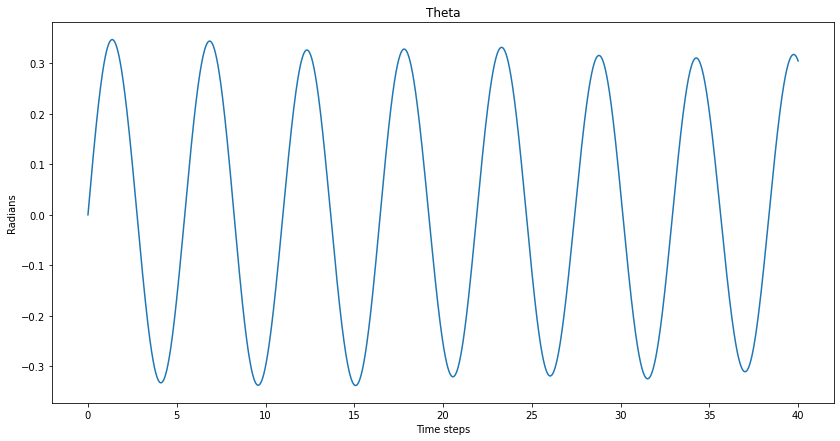

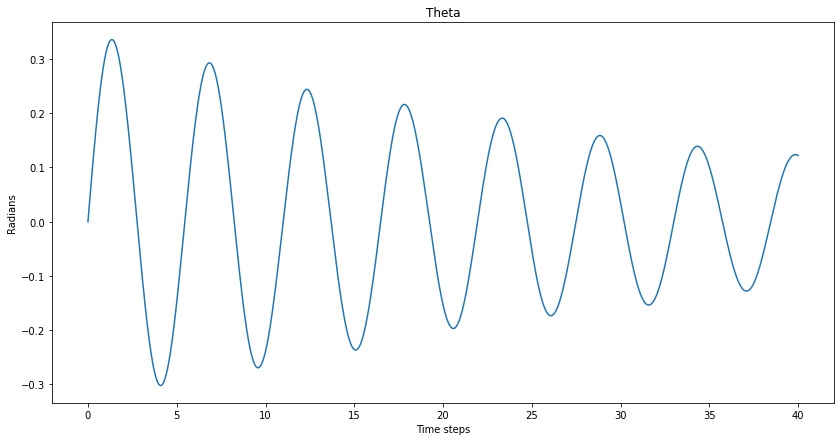

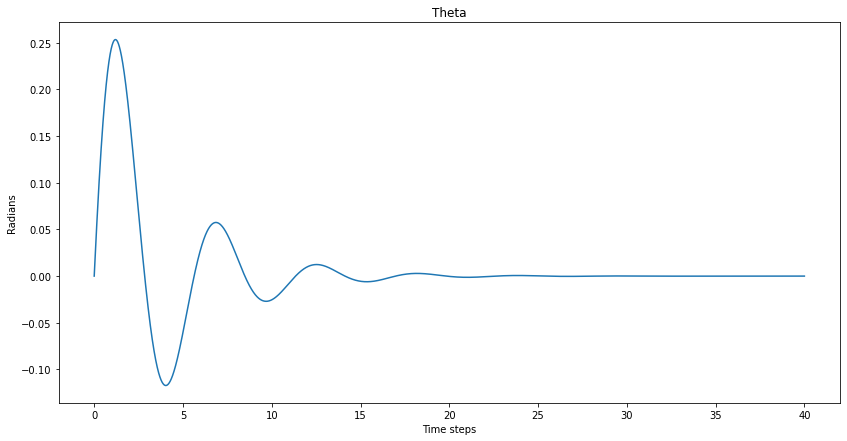

In [310]:
##### Defining the system #####

@jit(nopython=True)
def dwdtFourth(t,w,oParams):
    dw = np.array([
        w[1],
        (-A(gamma(w[0],w[3],oParams[2]))*sigma_0*g*h*np.sin(w[0])-oParams[0]*g*np.cos(w[0])*w[6]-oParams[3]*R*gamma(w[0],w[3],oParams[2])*w[1]*(w[3]-(R*(np.cos(gamma(w[0],w[3],oParams[2])/2)-1))) + w[5]*np.cos(oParams[4]*t)*w[3] )/I_C,
        w[4],
        w[5],
        ( oParams[0]*g*np.cos(w[0])*np.sin(w[0]) - oParams[2]*R*gamma(w[0],w[3],oParams[2])*w[1] + oParams[4]*np.cos(oParams[3]*t) )/(m+oParams[0]),
        g * (( A(gamma(w[0],w[3],oParams[2])) *sigma_0 - m - oParams[0] - oParams[0]*np.cos(w[0])**2)/(m+oParams[0])),
        w[7],
        -g*np.sin(w[0])
    ])
    return dw

w_0Fifth = np.array([
    0,
    0.4,
    0,
    y_0C,
    0,
    0,
    0,
    0
])


##### Defining a function for plotting the the angle theta of the system #####
def solveNPlotODE2(a,b,plotWidth,w_0,m_L,cargoFall,k_f,omega_w,F_0):
    otherParameters = np.array([m_L,cargoFall,beta,k_f,omega_w,F_0])

    solvedW, stepsT = ODEcargo(dwdtFourth,w_0,a,b,otherParameters)
    plt.figure(figsize=(plotWidth,7))

    plt.plot(stepsT,solvedW[:,0])
    plt.title("Theta")
    plt.xlabel("Time steps")
    plt.ylabel("Radians")

    plt.show()

solveNPlotODE2(0,40,14,w_0Fifth,0.0,True,100.0,0.0,0.0)
solveNPlotODE2(0,40,14,w_0Fifth,0.0,True,1000.0,0.0,0.0)
solveNPlotODE2(0,40,14,w_0Fifth,0.0,True,10000.0,0.0,0.0)


As the graphs for the angle $\theta$ show, the friction have a dampening effect on the rolling, as would be expected of friction. When that friction is small, the dampening is also small, while when the friction is large, the dampening is very noticeable. 

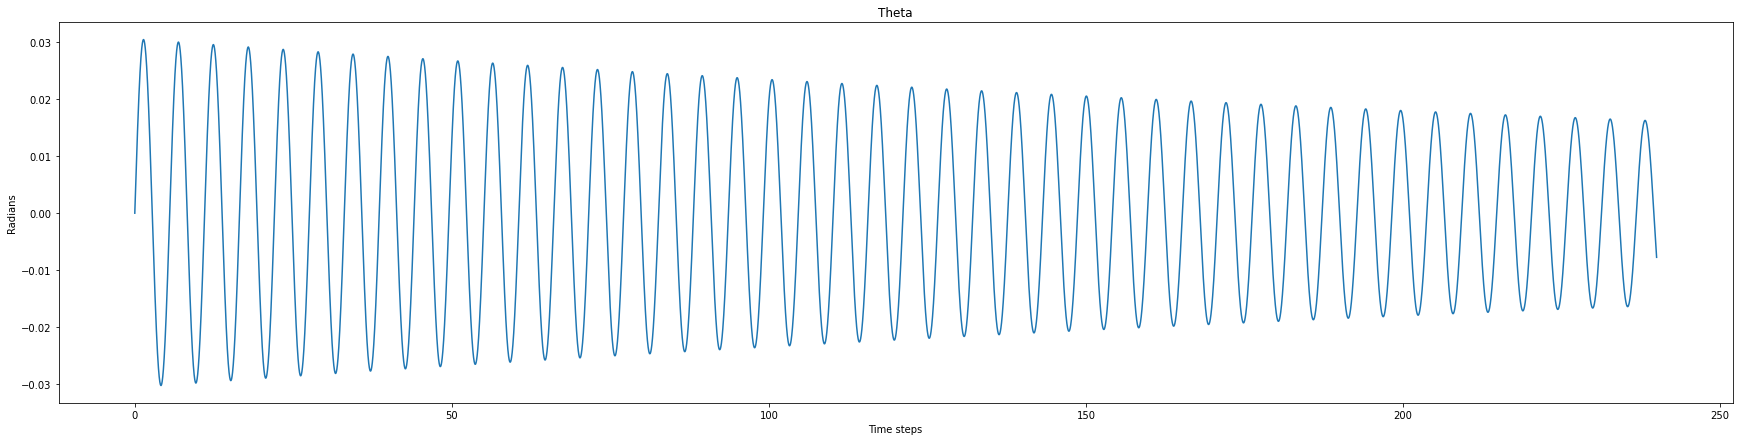

In [311]:
##### Defining a new set of initial values #####
w_0Sixth = np.array([
    0,
    2*np.pi * 2/360,
    0,
    y_0C,
    0,
    0,
    0,
    0
])

##### Potting the system with the initial values, and some new constants for the friciton and harmonic forces #####

omega_0 = np.sqrt(m*g*h/I_C)

solveNPlotODE2(0,240,30,w_0Sixth,0,True,100,0.93*omega_0,0.625*m*g)
